# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F
from tqdm import tqdm
from timeit import default_timer as timer

---
# Functions

In [2]:
#--------------------------------------------- Dataset ---------------------------------------------#

class Cifar10Dataset(Dataset):
    
    def __init__(self, imgs_list, classes, transforms):
        super(Cifar10Dataset, self).__init__()
        
        self.imgs_list = imgs_list
        self.class_to_int = {classes[i] : i for i in range(len(classes))}
        self.transforms = transforms
        
        
    def __getitem__(self, index):

        # Image path
        image_path = self.imgs_list[index]
        
        # Reading image
        image = Image.open(image_path)
        
        # Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        # Applying transforms on image
        image = self.transforms(image)
        
        return image, label
        

    def __len__(self):
        return len(self.imgs_list)
    
    
#------------------------------------- Sample Images Plotting -------------------------------------#

def sample_images(dataloader, title, classes):
    # Check out what's inside the training dataloader
    train_features_batch, train_labels_batch = next(iter(dataloader))

    plt.figure(figsize=(6, 5))
    nrows = 4
    ncols = 5
    for i in range(20):
        plt.subplot(nrows, ncols, i+1)
        img, label = train_features_batch[i], train_labels_batch[i]
        mean, std = 0.5, 0.5
        img = std * img + mean
        plt.imshow(img.permute(1, 2, 0))
        plt.title(classes[label], fontsize=7, pad=0)
        plt.axis("Off")

    plt.suptitle(title, fontsize=20, )
    plt.tight_layout(pad=1)
    
    
#------------------------------------ Accuracy Calculator Func ------------------------------------#

def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


#------------------------------------------- Train Step -------------------------------------------#

def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn=accuracy_fn):
    
    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        
    return train_loss, train_acc


#-------------------------------------------- Test Step --------------------------------------------#

def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn=accuracy_fn):
    
    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval() 
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(true=y.cpu(),
                                    pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss/counter, refresh=True)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)
            
    return test_loss, test_acc


#------------------------------------------ Training Func ------------------------------------------#

def Train(train_dataloader, test_dataloader, model, loss_fn, optimizer, scheduler, epochs):
    
    train_epoch_loss = []
    train_epoch_accuracy = []
    test_epoch_loss = []
    test_epoch_accuracy = []

    train_time_start = timer()

    for epoch in range(epochs):
        print("EPOCH {}/{} :".format(epoch +1, epochs))
        train_loss, train_acc = train_step(data_loader=train_dataloader,
                                           model=model, 
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           )
        test_loss, test_acc = test_step(data_loader=test_dataloader,
                                        model=model,
                                        loss_fn=loss_fn,
                                        )
        # decreasing the LR with scheduler
        scheduler.step()

        train_epoch_loss.append(train_loss)
        train_epoch_accuracy.append(train_acc)
        test_epoch_loss.append(test_loss)
        test_epoch_accuracy.append(test_acc)

    train_time_end = timer()
    total_time = train_time_end - train_time_start
    print(f"\n\nTrain time: {total_time:.3f} seconds")
    
    return train_epoch_loss, train_epoch_accuracy, test_epoch_loss, test_epoch_accuracy


#----------------------------------------- Loss & Acc Plots -----------------------------------------#

def accloss_plots(train_loss, test_loss, train_acc, test_acc, title):
  
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=20, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=20, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    plt.suptitle(title, fontsize=25)
    sns.despine()
    plt.show();
    
    
#---------------------------------------- Outliers Detection ----------------------------------------#
    
def inference_outliers(model, data_loader, threshold):
    model.eval()
    outlier, inlier = 0, 0
    with tqdm(data_loader, desc =f"threshold = {threshold:.2f}") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)
            test_pred_logits = F.softmax(test_pred, dim = 1)

            inlier += sum(test_pred_logits.max(dim=1).values >= threshold).item()
            outlier += sum(test_pred_logits.max(dim=1).values < threshold).item()

            test_tqdm.set_postfix(proportion=inlier/(inlier+outlier), refresh=True)
            
    return outlier, inlier

---
# 1. Class "Frog" Removed


## Loading Dataset

#### Image dirs

In [3]:
DIR_TRAIN = "/kaggle/input/cifar10/cifar10/train/"
DIR_VAL = "/kaggle/input/cifar10/cifar10/test/"

In [4]:
classes = os.listdir(DIR_TRAIN)
print(f"Total Classes: {len(classes)}\n")

train_imgs = []
val_imgs  = []
for i, _class in enumerate(classes):
    train_imgs += glob.glob(DIR_TRAIN + _class + '/*.png')
    val_imgs += glob.glob(DIR_VAL + _class + '/*.png')

print("\nTotal train images: ", len(train_imgs))
print("Total val images: ", len(val_imgs))

Total Classes: 10


Total train images:  50000
Total val images:  10000


#### Transformations

In [5]:
trnsfrms = [transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),]

#### Building datasets

In [6]:
# removing Frog class
removed_class = 'frog'
no_frog_classes = list(set(classes)-set([removed_class]))
no_frog_train_imgs = [img for img in train_imgs if removed_class not in img]
no_frog_val_imgs = [img for img in val_imgs if removed_class not in img]

# Datasets
no_frog_train_dataset = Cifar10Dataset(no_frog_train_imgs, no_frog_classes, transforms = transforms.Compose(trnsfrms))
no_frog_val_dataset = Cifar10Dataset(no_frog_val_imgs, no_frog_classes, transforms = transforms.Compose(trnsfrms[-2:]))

#### Building dataloaders

In [7]:
batchsize = 128

no_frog_train_dataloader = DataLoader(
    dataset = no_frog_train_dataset,
    batch_size = batchsize,
    num_workers = 2,
    shuffle = True
)

no_frog_val_dataloader = DataLoader(
    dataset = no_frog_val_dataset,
    batch_size = batchsize,
    num_workers = 2,
)

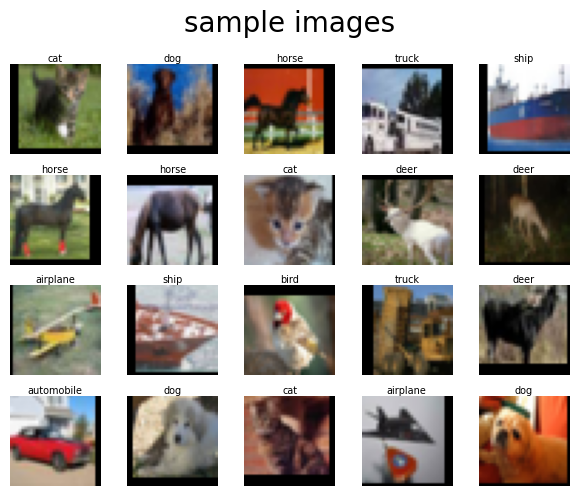

In [8]:
sample_images(no_frog_train_dataloader, 'sample images', no_frog_classes);

---
## Modeling Part:

#### Defining Model (Resnet18)

In [9]:
no_frog_resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
no_frog_resnet18_model.fc = nn.Linear(in_features=no_frog_resnet18_model.fc.in_features, 
                                      out_features=9)

# Loss Function & Optimizer
no_frog_CE_loss_fn = nn.CrossEntropyLoss()
no_frog_optimizer = torch.optim.Adam(no_frog_resnet18_model.parameters(), lr = 0.0001)
no_frog_scheduler = torch.optim.lr_scheduler.StepLR(no_frog_optimizer, step_size=20, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 94.5MB/s]


#### Training

In [10]:
no_frog_train_epoch_loss, no_frog_train_epoch_accuracy, no_frog_test_epoch_loss, no_frog_test_epoch_accuracy = Train(train_dataloader=no_frog_train_dataloader,
                                                                                                                     test_dataloader=no_frog_val_dataloader,
                                                                                                                     model=no_frog_resnet18_model,
                                                                                                                     loss_fn=no_frog_CE_loss_fn,
                                                                                                                     optimizer=no_frog_optimizer,
                                                                                                                     scheduler=no_frog_scheduler,
                                                                                                                     epochs=200)

EPOCH 1/200 :


  train: 100%|██████████| 352/352 [02:31<00:00,  2.33it/s, train_acc=58.6, train_loss=1.16]

   test: 100%|██████████| 71/71 [00:28<00:00,  2.53it/s, test_acc=72, test_loss=0.79]   


EPOCH 2/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.44it/s, train_acc=72.1, train_loss=0.788]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=75.2, test_loss=0.703]


EPOCH 3/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.44it/s, train_acc=76.1, train_loss=0.67] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=77.1, test_loss=0.641]


EPOCH 4/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.42it/s, train_acc=78.3, train_loss=0.61] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=78.7, test_loss=0.608]


EPOCH 5/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.46it/s, train_acc=80.1, train_loss=0.559]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=79.6, test_loss=0.59] 


EPOCH 6/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=81.4, train_loss=0.523]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=79.9, test_loss=0.586]


EPOCH 7/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=82.3, train_loss=0.492]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=81.6, test_loss=0.523]


EPOCH 8/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.43it/s, train_acc=83.4, train_loss=0.46] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=81.2, test_loss=0.529]


EPOCH 9/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=84.3, train_loss=0.441]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=82.2, test_loss=0.511]


EPOCH 10/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=85.1, train_loss=0.416]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.48it/s, test_acc=82.8, test_loss=0.501]


EPOCH 11/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.37it/s, train_acc=85.8, train_loss=0.397]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.16it/s, test_acc=82.5, test_loss=0.511]


EPOCH 12/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.43it/s, train_acc=86.4, train_loss=0.376]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.10it/s, test_acc=82.7, test_loss=0.5]  


EPOCH 13/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=87, train_loss=0.36]   

   test: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s, test_acc=83.7, test_loss=0.492]


EPOCH 14/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=87.7, train_loss=0.344]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.97it/s, test_acc=82.8, test_loss=0.516]


EPOCH 15/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=88.3, train_loss=0.327]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=83.9, test_loss=0.506]


EPOCH 16/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=88.7, train_loss=0.314]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.60it/s, test_acc=84, test_loss=0.484]  


EPOCH 17/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.43it/s, train_acc=89.2, train_loss=0.297]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=84.1, test_loss=0.497]


EPOCH 18/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, train_acc=89.5, train_loss=0.293]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.70it/s, test_acc=84.1, test_loss=0.489]


EPOCH 19/200 :


   test: 100%|██████████| 71/71 [00:09<00:00,  7.78it/s, test_acc=84.1, test_loss=0.5]  275]


EPOCH 20/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=90.3, train_loss=0.268]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=84.1, test_loss=0.515]


EPOCH 21/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=93.3, train_loss=0.188]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.50it/s, test_acc=85.5, test_loss=0.483]


EPOCH 22/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=94, train_loss=0.166]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=85.7, test_loss=0.496]


EPOCH 23/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=94.3, train_loss=0.156]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.02it/s, test_acc=85.6, test_loss=0.499]


EPOCH 24/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=94.8, train_loss=0.146]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.18it/s, test_acc=85.5, test_loss=0.512]


EPOCH 25/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=94.9, train_loss=0.143]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.73it/s, test_acc=85.7, test_loss=0.511]


EPOCH 26/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=95.3, train_loss=0.136]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.89it/s, test_acc=85.9, test_loss=0.531]


EPOCH 27/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, train_acc=95.4, train_loss=0.131]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=85.5, test_loss=0.534]


EPOCH 28/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.12it/s, train_acc=95.5, train_loss=0.13] 

   test: 100%|██████████| 71/71 [00:08<00:00,  7.94it/s, test_acc=85.7, test_loss=0.535]


EPOCH 29/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s, train_acc=95.5, train_loss=0.124]

   test: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s, test_acc=85.7, test_loss=0.539]


EPOCH 30/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.24it/s, train_acc=95.6, train_loss=0.121]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, test_acc=85.6, test_loss=0.546]


EPOCH 31/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s, train_acc=95.8, train_loss=0.119]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.13it/s, test_acc=85.6, test_loss=0.548]


EPOCH 32/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.16it/s, train_acc=95.9, train_loss=0.114]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.93it/s, test_acc=85.6, test_loss=0.557]


EPOCH 33/200 :


  train: 100%|██████████| 352/352 [00:51<00:00,  6.79it/s, train_acc=96, train_loss=0.111]  

   test: 100%|██████████| 71/71 [00:07<00:00,  8.89it/s, test_acc=85.8, test_loss=0.568]


EPOCH 34/200 :


   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=86, test_loss=0.568]  9]  


EPOCH 35/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=96.2, train_loss=0.106] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.39it/s, test_acc=85.6, test_loss=0.575]


EPOCH 36/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=96.4, train_loss=0.101] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.54it/s, test_acc=85.8, test_loss=0.588]


EPOCH 37/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.53it/s, train_acc=96.5, train_loss=0.101] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.14it/s, test_acc=85.7, test_loss=0.594]


EPOCH 38/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=96.5, train_loss=0.0978]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, test_acc=85.4, test_loss=0.606]


EPOCH 39/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=96.6, train_loss=0.0931]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.24it/s, test_acc=85.6, test_loss=0.613]


EPOCH 40/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.70it/s, train_acc=96.7, train_loss=0.0925]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.31it/s, test_acc=85.6, test_loss=0.605]


EPOCH 41/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=96.9, train_loss=0.085] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=85.6, test_loss=0.61] 


EPOCH 42/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97, train_loss=0.0827]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=85.7, test_loss=0.61] 


EPOCH 43/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.1, train_loss=0.0833]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.96it/s, test_acc=85.6, test_loss=0.612]


EPOCH 44/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.46it/s, train_acc=97.1, train_loss=0.0837]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.54it/s, test_acc=85.6, test_loss=0.615]


EPOCH 45/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=97.1, train_loss=0.0827]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=85.6, test_loss=0.615]


EPOCH 46/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=97.1, train_loss=0.0799]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.78it/s, test_acc=85.6, test_loss=0.617]


EPOCH 47/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.1, train_loss=0.0819]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=85.7, test_loss=0.618]


EPOCH 48/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=97.1, train_loss=0.0828]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.64it/s, test_acc=85.6, test_loss=0.62] 


EPOCH 49/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.44it/s, train_acc=97, train_loss=0.0833]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=85.6, test_loss=0.617]


EPOCH 50/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=97.2, train_loss=0.0796]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.38it/s, test_acc=85.6, test_loss=0.622]


EPOCH 51/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=97.2, train_loss=0.0795]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.50it/s, test_acc=85.7, test_loss=0.623]


EPOCH 52/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.2, train_loss=0.0781]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.55it/s, test_acc=85.5, test_loss=0.625]


EPOCH 53/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=97.3, train_loss=0.0786]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.39it/s, test_acc=85.7, test_loss=0.625]


EPOCH 54/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.2, train_loss=0.0798]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.97it/s, test_acc=85.6, test_loss=0.625]


EPOCH 55/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=97.3, train_loss=0.0769]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.84it/s, test_acc=85.6, test_loss=0.626]


EPOCH 56/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=97.4, train_loss=0.0763]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=85.7, test_loss=0.631]


EPOCH 57/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=97.1, train_loss=0.0797]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=85.6, test_loss=0.628]


EPOCH 58/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.49it/s, train_acc=97.3, train_loss=0.0784]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.07it/s, test_acc=85.6, test_loss=0.63] 


EPOCH 59/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.36it/s, train_acc=97.3, train_loss=0.0768]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=85.6, test_loss=0.631]


EPOCH 60/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=97.3, train_loss=0.0766]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.56it/s, test_acc=85.8, test_loss=0.631]


EPOCH 61/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.3, train_loss=0.0757]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=85.7, test_loss=0.63] 


EPOCH 62/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=97.3, train_loss=0.0772]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.55it/s, test_acc=85.7, test_loss=0.631]


EPOCH 63/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.2, train_loss=0.0771]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.631]


EPOCH 64/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.2, train_loss=0.0772]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=85.6, test_loss=0.631]


EPOCH 65/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.4, train_loss=0.0742]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.35it/s, test_acc=85.7, test_loss=0.631]


EPOCH 66/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.4, train_loss=0.0748]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.72it/s, test_acc=85.7, test_loss=0.631]


EPOCH 67/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.4, train_loss=0.0756]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.09it/s, test_acc=85.7, test_loss=0.631]


EPOCH 68/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.3, train_loss=0.0783]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=85.6, test_loss=0.631]


EPOCH 69/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=97.3, train_loss=0.0762]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.60it/s, test_acc=85.7, test_loss=0.631]


EPOCH 70/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=97.4, train_loss=0.0743]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.89it/s, test_acc=85.7, test_loss=0.631]


EPOCH 71/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0771]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=85.7, test_loss=0.631]


EPOCH 72/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=97.4, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.64it/s, test_acc=85.6, test_loss=0.631]


EPOCH 73/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=97.3, train_loss=0.0782]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=85.7, test_loss=0.631]


EPOCH 74/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=97.4, train_loss=0.0738]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=85.6, test_loss=0.632]


EPOCH 75/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.74it/s, train_acc=97.3, train_loss=0.0748]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.48it/s, test_acc=85.6, test_loss=0.632]


EPOCH 76/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=97.5, train_loss=0.0727]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.79it/s, test_acc=85.6, test_loss=0.632]


EPOCH 77/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.74it/s, train_acc=97.4, train_loss=0.0738]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.08it/s, test_acc=85.6, test_loss=0.632]


EPOCH 78/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=97.4, train_loss=0.075] 

   test: 100%|██████████| 71/71 [00:07<00:00,  8.88it/s, test_acc=85.7, test_loss=0.632]


EPOCH 79/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=97.4, train_loss=0.0767]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.78it/s, test_acc=85.7, test_loss=0.632]


EPOCH 80/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=97.4, train_loss=0.0764]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=85.7, test_loss=0.632]


EPOCH 81/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=97.4, train_loss=0.0749]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=85.7, test_loss=0.632]


EPOCH 82/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.78it/s, train_acc=97.4, train_loss=0.0746]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=85.7, test_loss=0.632]


EPOCH 83/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=97.4, train_loss=0.0756]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.78it/s, test_acc=85.7, test_loss=0.632]


EPOCH 84/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.71it/s, train_acc=97.4, train_loss=0.076] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.72it/s, test_acc=85.7, test_loss=0.632]


EPOCH 85/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.76it/s, train_acc=97.5, train_loss=0.0747]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.65it/s, test_acc=85.7, test_loss=0.632]


EPOCH 86/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.85it/s, train_acc=97.2, train_loss=0.0795]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.95it/s, test_acc=85.7, test_loss=0.632]


EPOCH 87/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=97.2, train_loss=0.0771]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.85it/s, test_acc=85.7, test_loss=0.632]


EPOCH 88/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=97.3, train_loss=0.0763]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.65it/s, test_acc=85.7, test_loss=0.632]


EPOCH 89/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.5, train_loss=0.0726]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=85.7, test_loss=0.632]


EPOCH 90/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.44it/s, train_acc=97.5, train_loss=0.0734]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.90it/s, test_acc=85.7, test_loss=0.632]


EPOCH 91/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.4, train_loss=0.0758]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=85.7, test_loss=0.632]


EPOCH 92/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=97.3, train_loss=0.0765]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=85.7, test_loss=0.632]


EPOCH 93/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.5, train_loss=0.0739]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=85.7, test_loss=0.632]


EPOCH 94/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.4, train_loss=0.0736]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.65it/s, test_acc=85.7, test_loss=0.632]


EPOCH 95/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=97.2, train_loss=0.0756]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=85.7, test_loss=0.632]


EPOCH 96/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.70it/s, train_acc=97.5, train_loss=0.0733]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.38it/s, test_acc=85.7, test_loss=0.632]


EPOCH 97/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=97.3, train_loss=0.0772]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=85.7, test_loss=0.632]


EPOCH 98/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.5, train_loss=0.0736]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=85.7, test_loss=0.632]


EPOCH 99/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=97.4, train_loss=0.0756]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=85.7, test_loss=0.633]


EPOCH 100/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.3, train_loss=0.0761]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=85.7, test_loss=0.633]


EPOCH 101/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.5, train_loss=0.0731]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s, test_acc=85.7, test_loss=0.633]


EPOCH 102/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.2, train_loss=0.0766]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=85.7, test_loss=0.633]


EPOCH 103/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.4, train_loss=0.0759]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=85.7, test_loss=0.633]


EPOCH 104/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.4, train_loss=0.0749]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.41it/s, test_acc=85.7, test_loss=0.633]


EPOCH 105/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=85.7, test_loss=0.633]


EPOCH 106/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.2, train_loss=0.0782]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 107/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.6, train_loss=0.0715]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.20it/s, test_acc=85.7, test_loss=0.633]


EPOCH 108/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0762]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=85.7, test_loss=0.633]


EPOCH 109/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=97.4, train_loss=0.0753]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, test_acc=85.7, test_loss=0.633]


EPOCH 110/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.49it/s, train_acc=97.4, train_loss=0.075] 

   test: 100%|██████████| 71/71 [00:07<00:00,  8.96it/s, test_acc=85.7, test_loss=0.633]


EPOCH 111/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=97.3, train_loss=0.0758]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.47it/s, test_acc=85.7, test_loss=0.633]


EPOCH 112/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=97.4, train_loss=0.0743]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.89it/s, test_acc=85.7, test_loss=0.633]


EPOCH 113/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=97.2, train_loss=0.0784]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=85.7, test_loss=0.633]


EPOCH 114/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.4, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=85.7, test_loss=0.633]


EPOCH 115/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.4, train_loss=0.076] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=85.7, test_loss=0.633]


EPOCH 116/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.4, train_loss=0.0747]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, test_acc=85.7, test_loss=0.633]


EPOCH 117/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=97.3, train_loss=0.0759]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.43it/s, test_acc=85.7, test_loss=0.633]


EPOCH 118/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.71it/s, train_acc=97.4, train_loss=0.0719]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.38it/s, test_acc=85.7, test_loss=0.633]


EPOCH 119/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=97.3, train_loss=0.0774]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.61it/s, test_acc=85.7, test_loss=0.633]


EPOCH 120/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.3, train_loss=0.0742]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.88it/s, test_acc=85.7, test_loss=0.633]


EPOCH 121/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.3, train_loss=0.0761]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.87it/s, test_acc=85.7, test_loss=0.633]


EPOCH 122/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.3, train_loss=0.0766]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.59it/s, test_acc=85.7, test_loss=0.633]


EPOCH 123/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.4, train_loss=0.0744]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.01it/s, test_acc=85.7, test_loss=0.633]


EPOCH 124/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.4, train_loss=0.0761]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=85.7, test_loss=0.633]


EPOCH 125/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.3, train_loss=0.0753]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=85.7, test_loss=0.633]


EPOCH 126/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=97.3, train_loss=0.0788]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.67it/s, test_acc=85.7, test_loss=0.633]


EPOCH 127/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.49it/s, train_acc=97.4, train_loss=0.0744]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.56it/s, test_acc=85.7, test_loss=0.633]


EPOCH 128/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.53it/s, train_acc=97.5, train_loss=0.0726]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.48it/s, test_acc=85.7, test_loss=0.633]


EPOCH 129/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.63it/s, train_acc=97.3, train_loss=0.0756]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.27it/s, test_acc=85.7, test_loss=0.633]


EPOCH 130/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=97.4, train_loss=0.0762]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.61it/s, test_acc=85.7, test_loss=0.633]


EPOCH 131/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.3, train_loss=0.074] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.70it/s, test_acc=85.7, test_loss=0.633]


EPOCH 132/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=97.3, train_loss=0.0759]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.01it/s, test_acc=85.7, test_loss=0.633]


EPOCH 133/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.3, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=85.7, test_loss=0.633]


EPOCH 134/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.5, train_loss=0.0744]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=85.7, test_loss=0.633]


EPOCH 135/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=97.4, train_loss=0.0747]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.91it/s, test_acc=85.7, test_loss=0.633]


EPOCH 136/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=97.4, train_loss=0.0744]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=85.7, test_loss=0.633]


EPOCH 137/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=97.5, train_loss=0.0745]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.41it/s, test_acc=85.7, test_loss=0.633]


EPOCH 138/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=97.3, train_loss=0.0784]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=85.7, test_loss=0.633]


EPOCH 139/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.2, train_loss=0.0779]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=85.7, test_loss=0.633]


EPOCH 140/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.65it/s, train_acc=97.3, train_loss=0.0767]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.32it/s, test_acc=85.7, test_loss=0.633]


EPOCH 141/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.2, train_loss=0.0777]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.50it/s, test_acc=85.7, test_loss=0.633]


EPOCH 142/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.5, train_loss=0.0736]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=85.7, test_loss=0.633]


EPOCH 143/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=97.4, train_loss=0.0764]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.99it/s, test_acc=85.7, test_loss=0.633]


EPOCH 144/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0747]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=85.7, test_loss=0.633]


EPOCH 145/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.3, train_loss=0.0765]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=85.7, test_loss=0.633]


EPOCH 146/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.3, train_loss=0.0765]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.95it/s, test_acc=85.7, test_loss=0.633]


EPOCH 147/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.53it/s, train_acc=97.4, train_loss=0.0761]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.03it/s, test_acc=85.7, test_loss=0.633]


EPOCH 148/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=97.5, train_loss=0.0739]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.14it/s, test_acc=85.7, test_loss=0.633]


EPOCH 149/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.4, train_loss=0.0748]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.79it/s, test_acc=85.7, test_loss=0.633]


EPOCH 150/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.40it/s, train_acc=97.3, train_loss=0.0762]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.64it/s, test_acc=85.7, test_loss=0.633]


EPOCH 151/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=97.3, train_loss=0.0746]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 152/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=97.4, train_loss=0.0752]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.24it/s, test_acc=85.7, test_loss=0.633]


EPOCH 153/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=97.4, train_loss=0.0753]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.50it/s, test_acc=85.7, test_loss=0.633]


EPOCH 154/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.4, train_loss=0.0754]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, test_acc=85.7, test_loss=0.633]


EPOCH 155/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=97.3, train_loss=0.0768]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=85.7, test_loss=0.633]


EPOCH 156/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.53it/s, train_acc=97.4, train_loss=0.0741]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.74it/s, test_acc=85.7, test_loss=0.633]


EPOCH 157/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=97.3, train_loss=0.0758]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.67it/s, test_acc=85.7, test_loss=0.633]


EPOCH 158/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=97.3, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.92it/s, test_acc=85.7, test_loss=0.633]


EPOCH 159/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.4, train_loss=0.0746]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.32it/s, test_acc=85.7, test_loss=0.633]


EPOCH 160/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.4, train_loss=0.0739]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=85.7, test_loss=0.633]


EPOCH 161/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.3, train_loss=0.0774]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.03it/s, test_acc=85.7, test_loss=0.633]


EPOCH 162/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.4, train_loss=0.0741]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=85.7, test_loss=0.633]


EPOCH 163/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=97.4, train_loss=0.0758]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.28it/s, test_acc=85.7, test_loss=0.633]


EPOCH 164/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.4, train_loss=0.0749]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=85.7, test_loss=0.633]


EPOCH 165/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.49it/s, train_acc=97.3, train_loss=0.0765]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 166/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=97.4, train_loss=0.0741]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.56it/s, test_acc=85.7, test_loss=0.633]


EPOCH 167/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.43it/s, train_acc=97.5, train_loss=0.0736]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, test_acc=85.7, test_loss=0.633]


EPOCH 168/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=97.3, train_loss=0.0782]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.61it/s, test_acc=85.7, test_loss=0.633]


EPOCH 169/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s, train_acc=97.4, train_loss=0.0757]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.29it/s, test_acc=85.7, test_loss=0.633]


EPOCH 170/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.46it/s, train_acc=97.3, train_loss=0.076] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.87it/s, test_acc=85.7, test_loss=0.633]


EPOCH 171/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.4, train_loss=0.0734]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.26it/s, test_acc=85.7, test_loss=0.633]


EPOCH 172/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=97.3, train_loss=0.0763]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=85.7, test_loss=0.633]


EPOCH 173/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=97.4, train_loss=0.0746]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=85.7, test_loss=0.633]


EPOCH 174/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.37it/s, train_acc=97.3, train_loss=0.0753]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=85.7, test_loss=0.633]


EPOCH 175/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.4, train_loss=0.0743]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.29it/s, test_acc=85.7, test_loss=0.633]


EPOCH 176/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, train_acc=97.4, train_loss=0.076] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=85.7, test_loss=0.633]


EPOCH 177/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=97.4, train_loss=0.0744]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 178/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=97.3, train_loss=0.0751]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.15it/s, test_acc=85.7, test_loss=0.633]


EPOCH 179/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, train_acc=97.3, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 180/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=97.5, train_loss=0.0742]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.91it/s, test_acc=85.7, test_loss=0.633]


EPOCH 181/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=97.3, train_loss=0.0765]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=85.7, test_loss=0.633]


EPOCH 182/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=97.4, train_loss=0.0732]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=85.7, test_loss=0.633]


EPOCH 183/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=97.4, train_loss=0.0743]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=85.7, test_loss=0.633]


EPOCH 184/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0776]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.70it/s, test_acc=85.7, test_loss=0.633]


EPOCH 185/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.49it/s, train_acc=97.4, train_loss=0.0766]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.39it/s, test_acc=85.7, test_loss=0.633]


EPOCH 186/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.42it/s, train_acc=97.3, train_loss=0.0755]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.70it/s, test_acc=85.7, test_loss=0.633]


EPOCH 187/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0766]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.35it/s, test_acc=85.7, test_loss=0.633]


EPOCH 188/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.3, train_loss=0.0756]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=85.7, test_loss=0.633]


EPOCH 189/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=97.5, train_loss=0.0743]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 190/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=97.4, train_loss=0.0743]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.32it/s, test_acc=85.7, test_loss=0.633]


EPOCH 191/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.4, train_loss=0.0742]

   test: 100%|██████████| 71/71 [00:08<00:00,  7.95it/s, test_acc=85.7, test_loss=0.633]


EPOCH 192/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.36it/s, train_acc=97.5, train_loss=0.0734]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.01it/s, test_acc=85.7, test_loss=0.633]


EPOCH 193/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=97.3, train_loss=0.0762]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.93it/s, test_acc=85.7, test_loss=0.633]


EPOCH 194/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=97.3, train_loss=0.0747]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=85.7, test_loss=0.633]


EPOCH 195/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.49it/s, train_acc=97.4, train_loss=0.0742]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.02it/s, test_acc=85.7, test_loss=0.633]


EPOCH 196/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=97.2, train_loss=0.0767]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.41it/s, test_acc=85.7, test_loss=0.633]


EPOCH 197/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, train_acc=97.3, train_loss=0.0768]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.56it/s, test_acc=85.7, test_loss=0.633]


EPOCH 198/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=97.3, train_loss=0.0763]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=85.7, test_loss=0.633]


EPOCH 199/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=97.3, train_loss=0.076] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.65it/s, test_acc=85.7, test_loss=0.633]


EPOCH 200/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=97.2, train_loss=0.077] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.59it/s, test_acc=85.7, test_loss=0.633]





Train time: 11124.318 seconds


#### Loss & Acc Plots

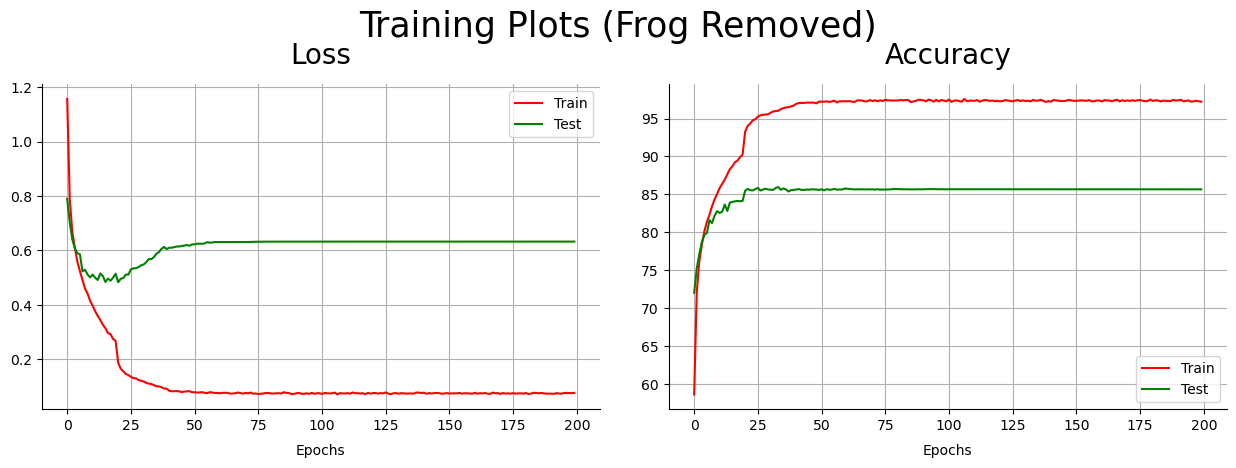

In [11]:
accloss_plots(no_frog_train_epoch_loss, no_frog_test_epoch_loss, no_frog_train_epoch_accuracy, no_frog_test_epoch_accuracy, title="Training Plots (Frog Removed)")

---
## Outliers Detection

#### Finding threshold

threshold = 0.00: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, proportion=1]

threshold = 0.05: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, proportion=1]

threshold = 0.10: 100%|██████████| 71/71 [00:07<00:00,  8.89it/s, proportion=1]

threshold = 0.15: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, proportion=1]

threshold = 0.20: 100%|██████████| 71/71 [00:07<00:00,  8.92it/s, proportion=1]

threshold = 0.25: 100%|██████████| 71/71 [00:08<00:00,  8.23it/s, proportion=1]

threshold = 0.30: 100%|██████████| 71/71 [00:08<00:00,  8.36it/s, proportion=1]

threshold = 0.35: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, proportion=0.999]

threshold = 0.40: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, proportion=0.997]

threshold = 0.45: 100%|██████████| 71/71 [00:08<00:00,  8.61it/s, proportion=0.993]

threshold = 0.50: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, proportion=0.988]

threshold = 0.55: 100%|██████████| 71/71 [00:07<00:00,  8.90it/s, proportion=0.976]

threshol

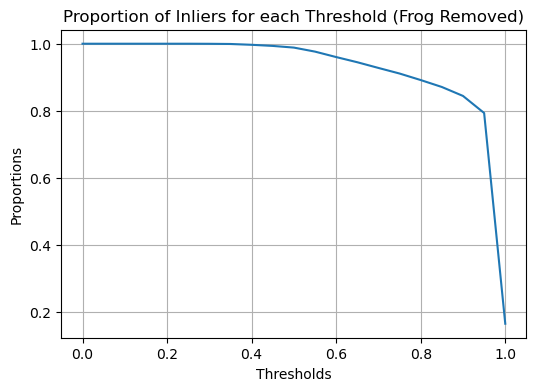

In [12]:
thresholds = np.arange(0, 1.01, 0.05)
no_frog_props = []
for t in thresholds:
    outlier, inlier = inference_outliers(model = no_frog_resnet18_model, data_loader = no_frog_val_dataloader, threshold = t)
    no_frog_props.append(inlier/(inlier+outlier))
    
plt.figure(figsize=(6,4))
plt.plot(thresholds, no_frog_props)
plt.xlabel('Thresholds')
plt.ylabel('Proportions')
plt.title('Proportion of Inliers for each Threshold (Frog Removed)')
plt.grid()


#### Outliers of removed class ( Frog )

In [13]:
frog_imgs = glob.glob('/kaggle/input/cifar10/cifar10/test/frog/*.png')
frog_dataset = Cifar10Dataset(frog_imgs, ['frog'], transforms = transforms.Compose(trnsfrms[2:]))
frog_dataloader = DataLoader(
    dataset = frog_dataset,
    batch_size = batchsize,
    num_workers = 2,
)

In [23]:
threshold = 0.64
frog_outlier, frog_inlier = inference_outliers(model = no_frog_resnet18_model, data_loader = frog_dataloader, threshold = threshold)

threshold = 0.64: 100%|██████████| 8/8 [00:01<00:00,  6.56it/s, proportion=0.843]


---
# 2. Class "Cat" Removed

## Loading Dataset

#### Building datasets

In [15]:
# removing Cat class
removed_class = 'cat'
no_cat_classes = list(set(classes)-set([removed_class]))
no_cat_train_imgs = [img for img in train_imgs if removed_class not in img]
no_cat_val_imgs = [img for img in val_imgs if removed_class not in img]

# Datasets
no_cat_train_dataset = Cifar10Dataset(no_cat_train_imgs, no_cat_classes, transforms = transforms.Compose(trnsfrms))
no_cat_val_dataset = Cifar10Dataset(no_cat_val_imgs, no_cat_classes, transforms = transforms.Compose(trnsfrms[-2:]))

#### Building dataloaders

In [16]:
batchsize = 128

no_cat_train_dataloader = DataLoader(
    dataset = no_cat_train_dataset,
    batch_size = batchsize,
    num_workers = 2,
    shuffle = True
)

no_cat_val_dataloader = DataLoader(
    dataset = no_cat_val_dataset,
    batch_size = batchsize,
    num_workers = 2,
)

---
## Modeling Part:

#### Defining Model (Resnet18)

In [17]:
no_cat_resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
no_cat_resnet18_model.fc = nn.Linear(in_features=no_cat_resnet18_model.fc.in_features, 
                                     out_features=9)

# Loss Function & Optimizer
no_cat_CE_loss_fn = nn.CrossEntropyLoss()
no_cat_optimizer = torch.optim.Adam(no_cat_resnet18_model.parameters(), lr = 0.0001)
no_cat_scheduler = torch.optim.lr_scheduler.StepLR(no_cat_optimizer, step_size=20, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#### Training

In [18]:
no_cat_train_epoch_loss, no_cat_train_epoch_accuracy, no_cat_test_epoch_loss, no_cat_test_epoch_accuracy = Train(train_dataloader=no_cat_train_dataloader,
                                                                                                                 test_dataloader=no_cat_val_dataloader,
                                                                                                                 model=no_cat_resnet18_model,
                                                                                                                 loss_fn=no_cat_CE_loss_fn,
                                                                                                                 optimizer=no_cat_optimizer,
                                                                                                                 scheduler=no_cat_scheduler,
                                                                                                                 epochs=200)

EPOCH 1/200 :


  train: 100%|██████████| 352/352 [01:00<00:00,  5.82it/s, train_acc=61.9, train_loss=1.08]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=75.6, test_loss=0.696]


EPOCH 2/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=75.1, train_loss=0.713]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.45it/s, test_acc=79.3, test_loss=0.606]


EPOCH 3/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=79.9, train_loss=0.587]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.48it/s, test_acc=80.1, test_loss=0.578]


EPOCH 4/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=81.8, train_loss=0.526]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=82.9, test_loss=0.499]


EPOCH 5/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=83.5, train_loss=0.477]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.49it/s, test_acc=83.7, test_loss=0.477]


EPOCH 6/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=84.8, train_loss=0.438]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.64it/s, test_acc=84.8, test_loss=0.457]


EPOCH 7/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.39it/s, train_acc=85.7, train_loss=0.412]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.15it/s, test_acc=84.1, test_loss=0.469]


EPOCH 8/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, train_acc=86.8, train_loss=0.383]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=85.5, test_loss=0.434]


EPOCH 9/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.18it/s, train_acc=87.4, train_loss=0.362]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=85.5, test_loss=0.452]


EPOCH 10/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.40it/s, train_acc=88.1, train_loss=0.341]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=85.1, test_loss=0.451]


EPOCH 11/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=88.7, train_loss=0.327]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=86.7, test_loss=0.404]


EPOCH 12/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=89.1, train_loss=0.312]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=85.6, test_loss=0.448]


EPOCH 13/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=89.8, train_loss=0.29] 

   test: 100%|██████████| 71/71 [00:07<00:00,  9.03it/s, test_acc=87.5, test_loss=0.398]


EPOCH 14/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.84it/s, train_acc=90.5, train_loss=0.272]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.69it/s, test_acc=87, test_loss=0.422]  


EPOCH 15/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=90.7, train_loss=0.264]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=86.6, test_loss=0.435]


EPOCH 16/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.81it/s, train_acc=91.3, train_loss=0.248]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.97it/s, test_acc=87.2, test_loss=0.408]


EPOCH 17/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.95it/s, train_acc=91.6, train_loss=0.241]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, test_acc=86.8, test_loss=0.417]


EPOCH 18/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.95it/s, train_acc=91.8, train_loss=0.23] 

   test: 100%|██████████| 71/71 [00:07<00:00,  9.50it/s, test_acc=87.4, test_loss=0.424]


EPOCH 19/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.82it/s, train_acc=92.2, train_loss=0.221]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.21it/s, test_acc=87.5, test_loss=0.422]


EPOCH 20/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.79it/s, train_acc=92.7, train_loss=0.206]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=87.3, test_loss=0.417]


EPOCH 21/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=95, train_loss=0.143]  

   test: 100%|██████████| 71/71 [00:07<00:00,  8.99it/s, test_acc=88.6, test_loss=0.393]


EPOCH 22/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=95.8, train_loss=0.121]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s, test_acc=88.8, test_loss=0.406]


EPOCH 23/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=95.9, train_loss=0.116]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=88.7, test_loss=0.412]


EPOCH 24/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.90it/s, train_acc=96.2, train_loss=0.107]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.94it/s, test_acc=88.6, test_loss=0.424]


EPOCH 25/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.87it/s, train_acc=96.2, train_loss=0.107]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=88.7, test_loss=0.427]


EPOCH 26/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=96.5, train_loss=0.101] 

   test: 100%|██████████| 71/71 [00:07<00:00,  8.99it/s, test_acc=88.6, test_loss=0.434]


EPOCH 27/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.88it/s, train_acc=96.6, train_loss=0.0975]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.24it/s, test_acc=88.8, test_loss=0.432]


EPOCH 28/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.81it/s, train_acc=96.8, train_loss=0.0912]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.12it/s, test_acc=88.6, test_loss=0.443]


EPOCH 29/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.86it/s, train_acc=96.9, train_loss=0.09]  

   test: 100%|██████████| 71/71 [00:07<00:00,  9.35it/s, test_acc=88.6, test_loss=0.444]


EPOCH 30/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.87it/s, train_acc=96.8, train_loss=0.0891]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.02it/s, test_acc=88.8, test_loss=0.449]


EPOCH 31/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.88it/s, train_acc=97, train_loss=0.0845]  

   test: 100%|██████████| 71/71 [00:07<00:00,  9.25it/s, test_acc=88.6, test_loss=0.463]


EPOCH 32/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=97, train_loss=0.0852]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.87it/s, test_acc=88.7, test_loss=0.456]


EPOCH 33/200 :


  train: 100%|██████████| 352/352 [00:43<00:00,  8.06it/s, train_acc=97.2, train_loss=0.0799]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.04it/s, test_acc=88.8, test_loss=0.463]


EPOCH 34/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.96it/s, train_acc=97.3, train_loss=0.0774]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.33it/s, test_acc=88.7, test_loss=0.475]


EPOCH 35/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.90it/s, train_acc=97.4, train_loss=0.0749]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.50it/s, test_acc=88.6, test_loss=0.478]


EPOCH 36/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.85it/s, train_acc=97.4, train_loss=0.073] 

   test: 100%|██████████| 71/71 [00:07<00:00,  9.07it/s, test_acc=88.7, test_loss=0.48] 


EPOCH 37/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.78it/s, train_acc=97.5, train_loss=0.071] 

   test: 100%|██████████| 71/71 [00:07<00:00,  9.06it/s, test_acc=88.3, test_loss=0.496]


EPOCH 38/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=97.6, train_loss=0.0703]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=88.4, test_loss=0.497]


EPOCH 39/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=97.7, train_loss=0.0661]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=88.4, test_loss=0.498]


EPOCH 40/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=97.7, train_loss=0.0656]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.88it/s, test_acc=88.7, test_loss=0.502]


EPOCH 41/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=97.9, train_loss=0.0605]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.74it/s, test_acc=88.9, test_loss=0.498]


EPOCH 42/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.79it/s, train_acc=98, train_loss=0.0588]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.61it/s, test_acc=88.8, test_loss=0.499]


EPOCH 43/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=98, train_loss=0.0603]  

   test: 100%|██████████| 71/71 [00:07<00:00,  8.92it/s, test_acc=88.8, test_loss=0.499]


EPOCH 44/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=98, train_loss=0.0581]  

   test: 100%|██████████| 71/71 [00:07<00:00,  9.16it/s, test_acc=88.8, test_loss=0.501]


EPOCH 45/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=98, train_loss=0.0571]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=88.7, test_loss=0.502]


EPOCH 46/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=98, train_loss=0.0572]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.78it/s, test_acc=88.8, test_loss=0.504]


EPOCH 47/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.65it/s, train_acc=98.2, train_loss=0.0541]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.13it/s, test_acc=88.9, test_loss=0.505]


EPOCH 48/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=98, train_loss=0.056]   

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=88.8, test_loss=0.505]


EPOCH 49/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.74it/s, train_acc=98, train_loss=0.0562]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.60it/s, test_acc=88.8, test_loss=0.506]


EPOCH 50/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=98.1, train_loss=0.0544]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, test_acc=88.8, test_loss=0.507]


EPOCH 51/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.70it/s, train_acc=98.1, train_loss=0.0553]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=88.8, test_loss=0.506]


EPOCH 52/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.79it/s, train_acc=98.2, train_loss=0.0526]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=88.8, test_loss=0.509]


EPOCH 53/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.74it/s, train_acc=98.2, train_loss=0.0516]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.97it/s, test_acc=88.7, test_loss=0.512]


EPOCH 54/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=98.2, train_loss=0.0523]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.00it/s, test_acc=88.8, test_loss=0.514]


EPOCH 55/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s, train_acc=98.1, train_loss=0.0557]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.07it/s, test_acc=88.8, test_loss=0.516]


EPOCH 56/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.14it/s, train_acc=98.1, train_loss=0.0538]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=88.7, test_loss=0.516]


EPOCH 57/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.1, train_loss=0.055] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=88.8, test_loss=0.515]


EPOCH 58/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=98.1, train_loss=0.0544]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.84it/s, test_acc=88.8, test_loss=0.517]


EPOCH 59/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, train_acc=98.2, train_loss=0.0539]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.25it/s, test_acc=88.9, test_loss=0.516]


EPOCH 60/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, train_acc=98.2, train_loss=0.0515]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.37it/s, test_acc=88.8, test_loss=0.519]


EPOCH 61/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=98.1, train_loss=0.0532]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s, test_acc=88.8, test_loss=0.519]


EPOCH 62/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=98.3, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:07<00:00,  8.94it/s, test_acc=88.8, test_loss=0.519]


EPOCH 63/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=98.2, train_loss=0.0519]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.64it/s, test_acc=88.8, test_loss=0.519]


EPOCH 64/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=98.2, train_loss=0.053] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.50it/s, test_acc=88.9, test_loss=0.519]


EPOCH 65/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.73it/s, train_acc=98.1, train_loss=0.0543]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=88.8, test_loss=0.519]


EPOCH 66/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.13it/s, test_acc=88.9, test_loss=0.519]


EPOCH 67/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=98.2, train_loss=0.0522]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, test_acc=88.8, test_loss=0.519]


EPOCH 68/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=98.2, train_loss=0.0527]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=88.8, test_loss=0.519]


EPOCH 69/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=98.3, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.13it/s, test_acc=88.8, test_loss=0.519]


EPOCH 70/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=98.1, train_loss=0.0542]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=88.8, test_loss=0.519]


EPOCH 71/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.82it/s, train_acc=98.3, train_loss=0.0504]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.85it/s, test_acc=88.8, test_loss=0.519]


EPOCH 72/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.77it/s, train_acc=98.3, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.95it/s, test_acc=88.8, test_loss=0.519]


EPOCH 73/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.82it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.72it/s, test_acc=88.8, test_loss=0.519]


EPOCH 74/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.74it/s, train_acc=98.2, train_loss=0.0516]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.28it/s, test_acc=88.8, test_loss=0.519]


EPOCH 75/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.75it/s, train_acc=98.2, train_loss=0.0519]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.73it/s, test_acc=88.8, test_loss=0.519]


EPOCH 76/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.71it/s, train_acc=98, train_loss=0.0553]  

   test: 100%|██████████| 71/71 [00:07<00:00,  9.10it/s, test_acc=88.9, test_loss=0.519]


EPOCH 77/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.73it/s, train_acc=98.2, train_loss=0.0518]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.87it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 78/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=98.3, train_loss=0.0498]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.01it/s, test_acc=88.8, test_loss=0.519]


EPOCH 79/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.70it/s, train_acc=98.2, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.79it/s, test_acc=88.8, test_loss=0.519]


EPOCH 80/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 81/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.79it/s, train_acc=98.2, train_loss=0.0516]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.10it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 82/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.2, train_loss=0.0508]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.79it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 83/200 :


  train: 100%|██████████| 352/352 [00:44<00:00,  7.85it/s, train_acc=98.2, train_loss=0.052] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.40it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 84/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.78it/s, train_acc=98.1, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.00it/s, test_acc=88.9, test_loss=0.52] 


EPOCH 85/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=98.1, train_loss=0.0541]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.11it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 86/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.85it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 87/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.3, train_loss=0.0514]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 88/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.2, train_loss=0.0517]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.12it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 89/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.2, train_loss=0.0539]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.72it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 90/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.76it/s, train_acc=98.3, train_loss=0.0505]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.72it/s, test_acc=88.9, test_loss=0.52] 


EPOCH 91/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.71it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.02it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 92/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.82it/s, train_acc=98.3, train_loss=0.0493]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.62it/s, test_acc=88.9, test_loss=0.52] 


EPOCH 93/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.81it/s, train_acc=98.2, train_loss=0.0521]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.55it/s, test_acc=88.9, test_loss=0.52] 


EPOCH 94/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.77it/s, train_acc=98.3, train_loss=0.0526]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.18it/s, test_acc=88.9, test_loss=0.52] 


EPOCH 95/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.2, train_loss=0.0518]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.15it/s, test_acc=88.9, test_loss=0.52] 


EPOCH 96/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.77it/s, train_acc=98.3, train_loss=0.0504]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 97/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=98.2, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.21it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 98/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  6.96it/s, train_acc=98.1, train_loss=0.0525]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.55it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 99/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s, train_acc=98.2, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.78it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 100/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  6.90it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  7.94it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 101/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.11it/s, train_acc=98.3, train_loss=0.0488]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.62it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 102/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.13it/s, train_acc=98.2, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 103/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=98.3, train_loss=0.049] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.34it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 104/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.39it/s, train_acc=98.2, train_loss=0.0508]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.70it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 105/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s, train_acc=98.3, train_loss=0.0498]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.20it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 106/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.37it/s, train_acc=98.3, train_loss=0.0497]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.38it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 107/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.44it/s, train_acc=98.3, train_loss=0.0509]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.26it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 108/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, train_acc=98.2, train_loss=0.0509]

   test: 100%|██████████| 71/71 [00:08<00:00,  7.90it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 109/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  6.98it/s, train_acc=98.2, train_loss=0.0516]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.57it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 110/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s, train_acc=98.2, train_loss=0.0514]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.74it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 111/200 :


  train: 100%|██████████| 352/352 [00:50<00:00,  6.98it/s, train_acc=98.3, train_loss=0.0506]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.77it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 112/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.07it/s, train_acc=98.3, train_loss=0.0509]

   test: 100%|██████████| 71/71 [00:09<00:00,  7.53it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 113/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.2, train_loss=0.0525]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 114/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=98.3, train_loss=0.0486]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.01it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 115/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.2, train_loss=0.0541]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.84it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 116/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 117/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=98.2, train_loss=0.0529]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.60it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 118/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=98.2, train_loss=0.0527]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 119/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=98.2, train_loss=0.0524]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.43it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 120/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=98.3, train_loss=0.0508]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.55it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 121/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=98.3, train_loss=0.0498]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.73it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 122/200 :


  train: 100%|██████████| 352/352 [00:49<00:00,  7.16it/s, train_acc=98.2, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.45it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 123/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.3, train_loss=0.0499]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 124/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.63it/s, train_acc=98.2, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.22it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 125/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=98.2, train_loss=0.0505]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 126/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=98.1, train_loss=0.0528]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.97it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 127/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=98.2, train_loss=0.0517]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.93it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 128/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.3, train_loss=0.0505]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 129/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=98.3, train_loss=0.049] 

   test: 100%|██████████| 71/71 [00:07<00:00,  9.14it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 130/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=98.3, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.77it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 131/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=98.2, train_loss=0.0518]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.67it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 132/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=98.2, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 133/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.76it/s, train_acc=98.3, train_loss=0.052] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 134/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.3, train_loss=0.052] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.55it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 135/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.3, train_loss=0.0516]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.33it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 136/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=98.2, train_loss=0.0524]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 137/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.63it/s, train_acc=98.2, train_loss=0.0516]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.87it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 138/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=98, train_loss=0.054]   

   test: 100%|██████████| 71/71 [00:07<00:00,  8.92it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 139/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.54it/s, train_acc=98.3, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.61it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 140/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.48it/s, train_acc=98.3, train_loss=0.0491]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.13it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 141/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.2, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.73it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 142/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.3, train_loss=0.0509]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 143/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.2, train_loss=0.0498]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.67it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 144/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=98.2, train_loss=0.0534]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.30it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 145/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.69it/s, train_acc=98.2, train_loss=0.0508]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.58it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 146/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.68it/s, train_acc=98.2, train_loss=0.0509]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 147/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.2, train_loss=0.0506]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.07it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 148/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.71it/s, train_acc=98.2, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.89it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 149/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=98.3, train_loss=0.0505]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.65it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 150/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=98.2, train_loss=0.0509]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.14it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 151/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.77it/s, train_acc=98.1, train_loss=0.0539]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.52it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 152/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=98.2, train_loss=0.0514]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.90it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 153/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=98.3, train_loss=0.0499]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 154/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=98.1, train_loss=0.0542]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.28it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 155/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.3, train_loss=0.0489]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.31it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 156/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.3, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.16it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 157/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.2, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.98it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 158/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.3, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:07<00:00,  8.91it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 159/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.49it/s, train_acc=98.2, train_loss=0.0536]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 160/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.61it/s, train_acc=98.3, train_loss=0.0507]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.64it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 161/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.52it/s, train_acc=98.2, train_loss=0.0515]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.01it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 162/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.63it/s, train_acc=98.2, train_loss=0.0531]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.63it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 163/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.60it/s, train_acc=98.2, train_loss=0.0515]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.50it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 164/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.1, train_loss=0.0518]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 165/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.57it/s, train_acc=98.3, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.53it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 166/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.65it/s, train_acc=98.3, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.35it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 167/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.58it/s, train_acc=98.2, train_loss=0.0514]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.28it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 168/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.65it/s, train_acc=98.3, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.67it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 169/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=98.2, train_loss=0.0525]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.71it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 170/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.51it/s, train_acc=98.3, train_loss=0.0505]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.81it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 171/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.62it/s, train_acc=98.2, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.59it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 172/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.63it/s, train_acc=98.2, train_loss=0.0529]

   test: 100%|██████████| 71/71 [00:07<00:00,  9.06it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 173/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=98.3, train_loss=0.05]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.59it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 174/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.72it/s, train_acc=98.2, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 175/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.3, train_loss=0.052] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.46it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 176/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s, train_acc=98.3, train_loss=0.0505]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.18it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 177/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, train_acc=98.2, train_loss=0.0513]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.31it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 178/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.43it/s, train_acc=98.2, train_loss=0.0527]

   test: 100%|██████████| 71/71 [00:08<00:00,  7.91it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 179/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=98.3, train_loss=0.0486]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.20it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 180/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s, train_acc=98.2, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:09<00:00,  7.50it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 181/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.42it/s, train_acc=98.1, train_loss=0.053] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 182/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, train_acc=98.3, train_loss=0.0495]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.99it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 183/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.38it/s, train_acc=98.2, train_loss=0.051] 

   test: 100%|██████████| 71/71 [00:08<00:00,  8.48it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 184/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.45it/s, train_acc=98.1, train_loss=0.0545]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.59it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 185/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.50it/s, train_acc=98.3, train_loss=0.0496]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.82it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 186/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.49it/s, train_acc=98.2, train_loss=0.0512]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.92it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 187/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.56it/s, train_acc=98.3, train_loss=0.0511]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.51it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 188/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=98.2, train_loss=0.0519]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 189/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.53it/s, train_acc=98.3, train_loss=0.0521]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.75it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 190/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=98.2, train_loss=0.0503]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.55it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 191/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.64it/s, train_acc=98.3, train_loss=0.0504]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.40it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 192/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.65it/s, train_acc=98.1, train_loss=0.0538]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.48it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 193/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.66it/s, train_acc=98.2, train_loss=0.0532]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.95it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 194/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=98.2, train_loss=0.0523]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 195/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.59it/s, train_acc=98.2, train_loss=0.0515]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.67it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 196/200 :


  train: 100%|██████████| 352/352 [00:46<00:00,  7.55it/s, train_acc=98.2, train_loss=0.05]  

   test: 100%|██████████| 71/71 [00:08<00:00,  8.35it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 197/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.22it/s, train_acc=98.2, train_loss=0.0514]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.66it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 198/200 :


  train: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, train_acc=98.2, train_loss=0.0526]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.42it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 199/200 :


  train: 100%|██████████| 352/352 [00:47<00:00,  7.47it/s, train_acc=98.2, train_loss=0.0514]

   test: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, test_acc=88.8, test_loss=0.52] 


EPOCH 200/200 :


  train: 100%|██████████| 352/352 [00:45<00:00,  7.67it/s, train_acc=98.2, train_loss=0.0534]

   test: 100%|██████████| 71/71 [00:07<00:00,  8.90it/s, test_acc=88.8, test_loss=0.52] 





Train time: 10931.614 seconds


#### Loss & Acc Plots

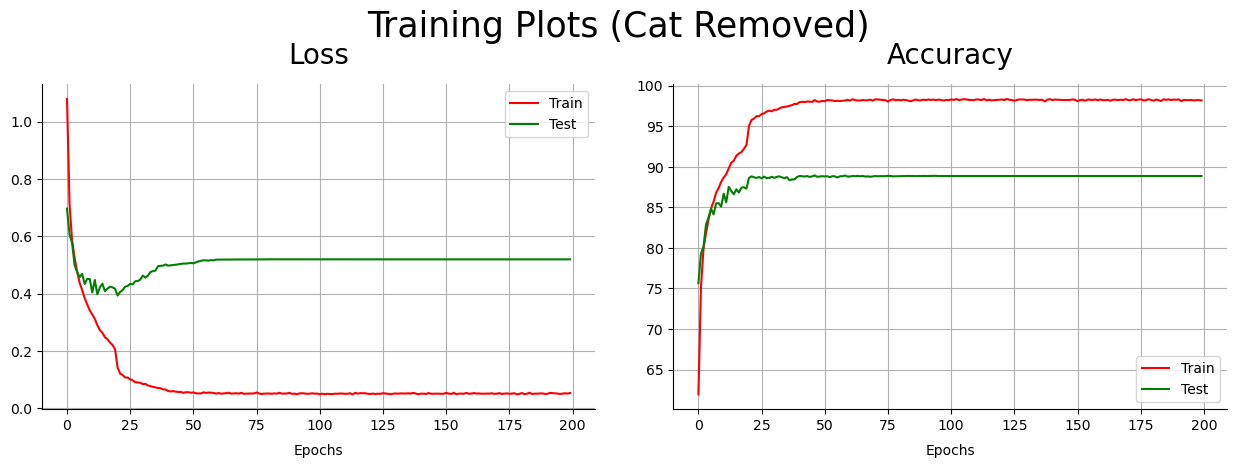

In [19]:
accloss_plots(no_cat_train_epoch_loss, no_cat_test_epoch_loss, no_cat_train_epoch_accuracy, no_cat_test_epoch_accuracy, title="Training Plots (Cat Removed)")

---
## Outliers Detection

#### Finding threshold

threshold = 0.00: 100%|██████████| 71/71 [00:08<00:00,  8.78it/s, proportion=1]

threshold = 0.05: 100%|██████████| 71/71 [00:08<00:00,  8.47it/s, proportion=1]

threshold = 0.10: 100%|██████████| 71/71 [00:07<00:00,  8.90it/s, proportion=1]

threshold = 0.15: 100%|██████████| 71/71 [00:08<00:00,  8.68it/s, proportion=1]

threshold = 0.20: 100%|██████████| 71/71 [00:08<00:00,  8.57it/s, proportion=1]

threshold = 0.25: 100%|██████████| 71/71 [00:08<00:00,  8.40it/s, proportion=1]

threshold = 0.30: 100%|██████████| 71/71 [00:08<00:00,  8.76it/s, proportion=1]

threshold = 0.35: 100%|██████████| 71/71 [00:08<00:00,  8.60it/s, proportion=1]    

threshold = 0.40: 100%|██████████| 71/71 [00:08<00:00,  8.80it/s, proportion=0.998]

threshold = 0.45: 100%|██████████| 71/71 [00:08<00:00,  8.70it/s, proportion=0.996]

threshold = 0.50: 100%|██████████| 71/71 [00:08<00:00,  8.86it/s, proportion=0.992]

threshold = 0.55: 100%|██████████| 71/71 [00:08<00:00,  8.38it/s, proportion=0.981]

threshol

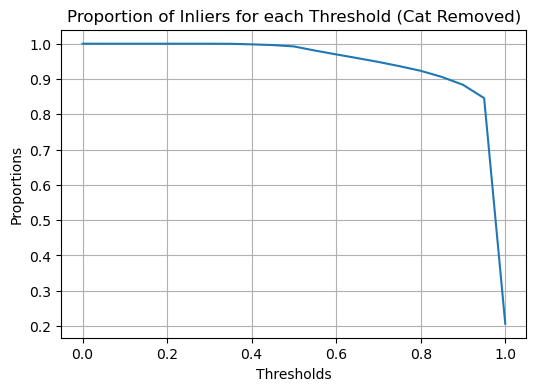

In [20]:
no_cat_props = []
for t in thresholds:
    outlier, inlier = inference_outliers(model = no_cat_resnet18_model, data_loader = no_cat_val_dataloader, threshold = t)
    no_cat_props.append(inlier/(inlier+outlier))
    
plt.figure(figsize=(6,4))
plt.plot(thresholds, no_cat_props)
plt.xlabel('Thresholds')
plt.ylabel('Proportions')
plt.title('Proportion of Inliers for each Threshold (Cat Removed)')
plt.grid()


#### Outliers of removed class ( Cat )

In [21]:
cat_imgs = glob.glob('/kaggle/input/cifar10/cifar10/test/cat/*.png')
cat_dataset = Cifar10Dataset(cat_imgs, ['cat'], transforms = transforms.Compose(trnsfrms[2:]))
cat_dataloader = DataLoader(
    dataset = cat_dataset,
    batch_size = batchsize,
    num_workers = 2,
)

In [24]:
threshold = 0.69
cat_outlier, cat_inlier = inference_outliers(model = no_cat_resnet18_model, data_loader = cat_dataloader, threshold = threshold)

threshold = 0.69: 100%|██████████| 8/8 [00:01<00:00,  7.44it/s, proportion=0.831]


---

<div align=center lang="fa"><font face="Tahoma" size="5" color=#c4c4c4>End</font></div>

---